# Official Results for 'Discovering Foodborne Illness in Online Restaurant Reviews' in JAMIA, 2017

This notebook presents the official evaluation of classifiers presented in the paper.

Because of licensing restrictions, we cannot publish the data used in the experiments.

However, the final trained models may be found in the `best_models` directory for inspection and further experimentation.

Additionally, those models are all retrained on the full training data within this notebook with a fixed random seed so that the final numbers could be reproduced if needed.

For inqueries about the results, models, or data, please contact [Tom Effland](mailto:teffland@cs.columbia.edu).

## Table of Contents

1. [Derivations of Selection Bias Corrections](#Selection-Bias-Correction)
    1. [Training](#Training:-Error-Rate)
    2. [Testing](#Testing)
    
2. [Setup](#Setup)
    1. [Data Ingestion](#Data-Ingestion) (Data is cleaned ahead of time)
    4. [Loading Models](#Loading-Models) (Model hyperparams are pre-tuned)
3. [Sick Task](#Sick-Task)
    1. [Logistic Regression](#Sick:-Logistic-Regression)
        1. [Precision Recall Tradeoffs](#Precision-Recall-Tradeoffs)
    2. [Random Forest](#Sick:-Random-Forest)
    3. [SVM](#Sick:-SVM)
    4. [Prototype](#Sick:-Prototype)
4. [Multiple Task](#Multiple-Task)
    1. [Logistic Regression](#Multiple:-Logistic-Regression)
    2. [Random Forest](#Multiple:-Random-Forest)
    3. [SVM](#Multiple:-SVM)
    4. [Pipelined Logistic Regression](#Multiple:-Pipelined-Logistic-Regression)
    5. [Prototype](#Multiple:-Prototype)

# Selection Bias Correction

Let $T(x)$ be the biased selection process for labelling data at DOHMH. We treat it as a black-box and model it atomically.

Let $U$ be the set of all Yelp Reviews that have been processed by the system.

Let $B \subset U$ s.t. $B = \{(x,y) | T(x) = 1\}$. $B$ is the biased training set.

Let $B^c \subseteq U \setminus B = \{(x,y) | T(x) = 0\}$. $B^c$ is the biased complement training set.

## Training: Error Rate

We can model the error rate of some classifier $f$ as:

$p(f(x) \ne y) = p(f(x) \ne y | T(x) = 1)p(T(x) = 1) + p(f(x) \ne y | T(x) = 0)p(T(x) = 0)$

and use plugin estimates:

$\hat{p}(T(x) = 1) = \frac{|B|}{|U|}$ (the % of labeled points)

$\hat{p}(f(x) \neq y | T(x)=1) = \frac{1}{|B|}\Sigma_{(x,y) \in B}{I[f(x) \neq y]}$

likewise,

$\hat{p}(f(x) \neq y | T(x)=0) = \frac{1}{|B^c|}\Sigma_{(x,y) \in B^c}{I[f(x) \neq y]}$

therefore

$\hat{p}(f(x) \neq y) = w_B\Sigma_{(x,y) \in B}{I[f(x) \neq y]} + w_{B^c}\Sigma_{(x,y) \in B^c}{I[f(x) \neq y]}$

where 

$w_B = \frac{1}{|U|}$ and $w_{B^c} = (1 - \frac{|B|}{|U|})(\frac{1}{|B^c|})$

Note that when $B^c$ is the entire complement of $B$, then $w_{B^c}$ reduces to $\frac{1}{|U|}$

So, if we are trying to minimize the classification error in the objective function then these are the sample weights to be used when calculating the error

## Testing

We will evaluate models using the F1 score and AUPR metric, calculated empirically on the dev and test sets.

We can bias-correct these the same way, using bias corrections for the precision and recall. Consider the probabilistic form of precision for some classifier $f$:

#### Precision

Let $U$ be the test set.

$Precision = p(y=1|f(x)=1) = \Sigma_{t}{p(y=1 | f(x)=1, T(x) = t)p(T(x)=t|f(x)=1)}$

Let $U_P \subset U$ be the set $\{(x,y) | f(x) = 1\}$. 

**Note** that $U_P$ varies with the classification threshold.

Then as with the error rate, we can find plugin estimates for the necessary quanities.

$\hat{p}(T(x) = 1|f(x)=1) = \frac{1}{|U_P|} \Sigma_{(x,y) \in B}{I[f(x)=1]} = \frac{|B \cap U_P|}{|U_P|}$

and so $\hat{p}(T(x) = 0|f(x)=1) = 1 - \frac{|B \cap U_P|}{|U_P|}$

Also,

$\hat{p}(y=1|f(x)=1, T(x)=1) = \frac{1}{|U_P|} \Sigma_{(x,y) \in B\cap U_P}{I[y=1]} 
 $

and $\hat{p}(y=1|f(x)=1, T(x)=0) = \frac{1}{|U_P|} \Sigma_{(x,y) \in B^c\cap U_P}{I[y=1]}$

Therefore

$Precision = \frac{|B \cap U_P|}{|U_P|} \frac{1}{|U_P|} \Sigma_{(x,y) \in B\cap U_P}{I[y=1]} 
+ (1 - \frac{|B \cap U_P|}{|U_P|})\frac{1}{|U_P|} \Sigma_{(x,y) \in B^c\cap U_P}{I[y=1]}$

#### Recall

The derivation for improtance-weighted (IW) recall follows similary to IW precision.

$Recall = p(f(x)=1|y=1) = \Sigma_{t}{p(f(x)=1| y=1, T(x) = t)p(T(x)=t|y=1)}$

Let $U_R \subset U$ be the set $\{(x,y) | y = 1\}$. 

**Note** that $U_R$ **does not** vary with the classification threshold.

The plugin estimates are:

$\hat{p}(T(x) = 1|y=1) = \frac{1}{|U_R|} \Sigma_{(x,y) \in B}{I[y=1]} = \frac{|B \cap U_R|}{|U_R|}$

and so $\hat{p}(T(x) = 0|y=1) = 1 - \frac{|B \cap U_R|}{|U_R|}$

Also,

$\hat{p}(f(x)=1 |y=1, T(x)=1) = \frac{1}{|U_R|} \Sigma_{(x,y) \in B\cap U_R}{I[f(x)=1]}$

and $\hat{p}(f(x)=1|y=1, T(x)=0) = \frac{1}{|U_R|} \Sigma_{(x,y) \in B^c\cap U_R}{I[f(x)=1]}$

plugging in we have

$ Recall =  \frac{|B \cap U_R|}{|U_R|} \frac{1}{|U_R|} \Sigma_{(x,y) \in B\cap U_R}{I[f(x)=1]}
+ (1 - \frac{|B \cap U_R|}{|U_R|}) \frac{1}{|U_R|} \Sigma_{(x,y) \in B^c\cap U_R}{I[f(x)=1]}$

#### AUPR Curve

Finally, using the above plugin estimates, we can balance data from both $B$ and (a sample from) $B^c$.  We can obtain a series of ordered Precision-Recall points $E = \{(p,r,t)_i | r_i \leq r_{i'}\}$ by varying the classification threshold $t \in [0,1]$ and then using trapezoidal integration to approximate the area under the Recall vs. Precision curve.

#### Bootstrap

For the final evaluation, we would like confidence intervals about the F1 and AUPR. We find these by using the percentile bootstrap:

We calculate bootstrap statistics for the IW-Precision, IW-Recall, and IW-AUPR as follows:

First we calculate the statistic $\bar{x}$ (for each of IW-Precision, IW-Recall, and IW-AUPR).

Then we resample the test dataset with replacement $B$ times and obtain the bootstrap statisic estimates for each set.

Call these $x_1, ...,  x_B$.

Then we can compute confidence intervals around $\bar{x}$ the usual way by finding the $\alpha=.025$ boundary quantiles $\delta_{\alpha}, \delta_{1-\alpha}$, such that 

$$P(\bar{x}^* - \delta_{1-\alpha} \leq \bar{x} \leq \bar{x}^* - \delta_{\alpha}) = .95$$

# Setup

In [1]:
import time
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
from __future__ import print_function

In [2]:
from experiments.baseline_experiment_util import *

In [3]:
random_seed = 0

## Data Ingestion

In [4]:
biased_data = setup_baseline_data(data_path='data', train_regime='biased', test_regime='gold', random_seed=random_seed)
gold_data = setup_baseline_data(data_path='data', train_regime='gold', test_regime='gold', random_seed=random_seed)
silver_data = setup_baseline_data(data_path='data', train_regime='silver', test_regime='gold', random_seed=random_seed)

In [5]:
# train setup
biased_text = np.array(biased_data['train_data']['text'])
biased_sick = np.array(biased_data['train_data']['is_foodborne'])
biased_mult = np.array(biased_data['train_data']['is_multiple'])
biased_weights = calc_train_importance_weights(biased_data['train_data']['is_biased'], biased_data['U'])

gold_text = np.array(gold_data['train_data']['text'])
gold_sick = np.array(gold_data['train_data']['is_foodborne'])
gold_mult = np.array(gold_data['train_data']['is_multiple'])
gold_weights = calc_train_importance_weights(gold_data['train_data']['is_biased'], gold_data['U'])

silver_text = np.array(silver_data['train_data']['text'])
silver_sick = np.array(silver_data['train_data']['is_foodborne'])
silver_mult = np.array(silver_data['train_data']['is_multiple'])
silver_weights = calc_train_importance_weights(silver_data['train_data']['is_biased'], silver_data['U'])

# test setup
test_data = gold_data['test_data']
B = 1000 # number of bootstrap test set resamples
all_results = {}

## Loading Models

In [6]:
from experiments.lr_model import model as lr_model
from experiments.rf_model import model as rf_model
from experiments.svm_model import model as svm_model
from sklearn.externals import joblib

In [7]:
# logistic regression sick models
best_sick_lr_biased = joblib.load('experiments/best_models/best_lr_sick_biased.pkl')
best_sick_lr_gold = joblib.load('experiments/best_models/best_lr_sick_gold.pkl')
best_sick_lr_silver = joblib.load('experiments/best_models/best_lr_sick_silver.pkl')

In [8]:
# random forest sick models
best_sick_rf_biased = joblib.load('experiments/best_models/best_rf_sick_biased.pkl')
best_sick_rf_gold = joblib.load('experiments/best_models/best_rf_sick_gold.pkl')
best_sick_rf_silver = joblib.load('experiments/best_models/best_rf_sick_silver.pkl')

In [9]:
# svm sick models
best_sick_svm_biased = joblib.load('experiments/best_models/best_svm_sick_biased.pkl')
best_sick_svm_gold = joblib.load('experiments/best_models/best_svm_sick_gold.pkl')
best_sick_svm_silver = joblib.load('experiments/best_models/best_svm_sick_silver.pkl')

In [10]:
# logistic regression multiple models
best_mult_lr_biased = joblib.load('experiments/best_models/best_lr_mult_biased.pkl')
best_mult_lr_gold = joblib.load('experiments/best_models/best_lr_mult_gold.pkl')
best_mult_lr_silver = joblib.load('experiments/best_models/best_lr_mult_silver.pkl')

In [11]:
# random forest multiple models
best_mult_rf_biased = joblib.load('experiments/best_models/best_rf_mult_biased.pkl')
best_mult_rf_gold = joblib.load('experiments/best_models/best_rf_mult_gold.pkl')
best_mult_rf_silver = joblib.load('experiments/best_models/best_rf_mult_silver.pkl')

In [12]:
# svm multiple models
best_mult_svm_biased = joblib.load('experiments/best_models/best_svm_mult_biased.pkl')
best_mult_svm_gold = joblib.load('experiments/best_models/best_svm_mult_gold.pkl')
best_mult_svm_silver = joblib.load('experiments/best_models/best_svm_mult_silver.pkl')

## Sick Task

Here are the notable stats for testing on the Sick task:
* All the test data is from 1/1/2017 and later
* It's about 2/3 biased and 1/3 nonbiased (1975 and 1000 reviews, respectively)
* All 1000 nonbiased reviews are have `No` labels
* The 1975 biased reviews are about 52% `Yes`/`No` (1026/949)

### Sick: Logistic Regression

In [13]:
best_sick_lr_biased.fit(biased_text, biased_sick, logreg__sample_weight=biased_weights)
best_sick_lr_gold.fit(gold_text, gold_sick, logreg__sample_weight=gold_weights)
best_sick_lr_silver.fit(silver_text, silver_sick, logreg__sample_weight=silver_weights)
print()


B: 999/1000
B: 999/1000
B: 999/1000
577 seconds for evaluation



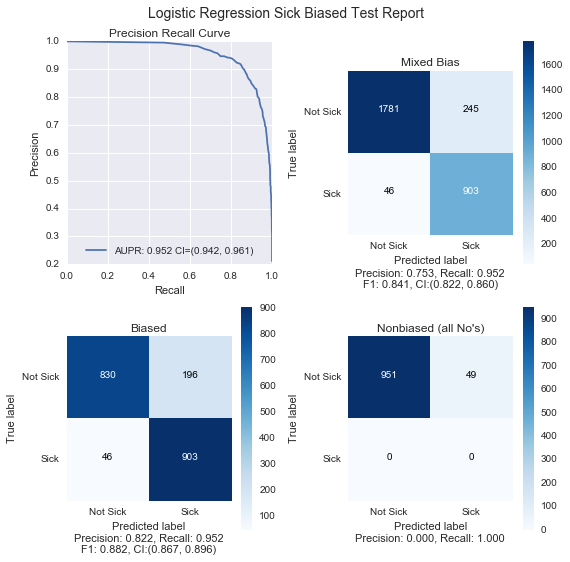

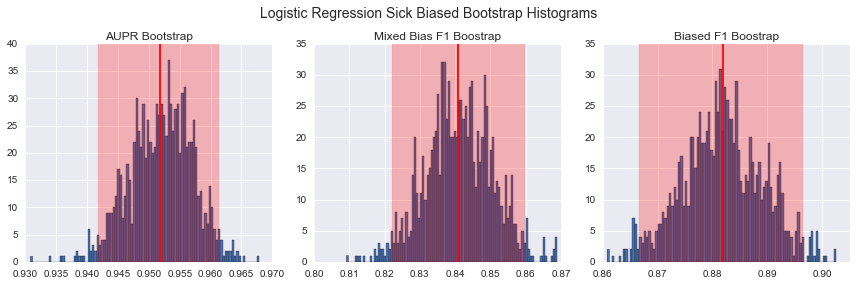

In [14]:
start = time.time()
title = 'Logistic Regression Sick Biased'
all_results[title] = model_report(best_sick_lr_biased, title, 'is_foodborne',
                                  test_data=test_data,
                                  save_fname='figures/sick_lr_biased',
                                  B=B, random_seed=random_seed)
print('\n{} seconds for evaluation'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
607 seconds



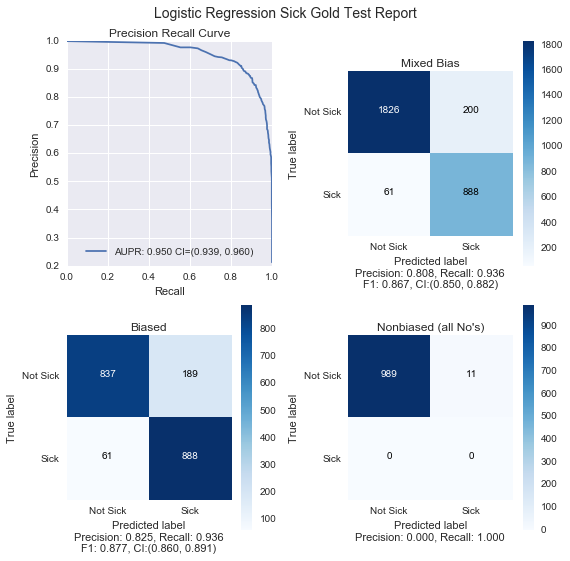

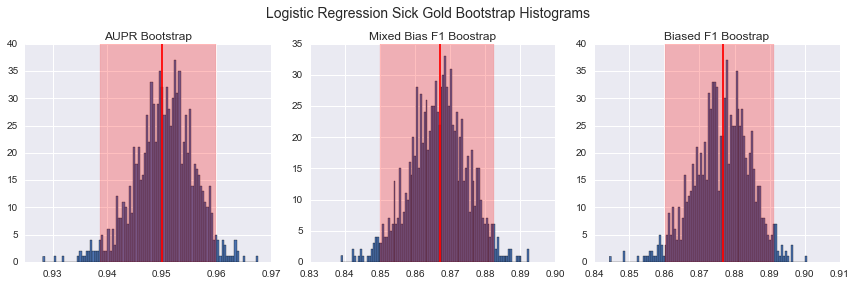

In [15]:
start = time.time()
title = 'Logistic Regression Sick Gold'
all_results[title] = model_report(best_sick_lr_gold, title, 'is_foodborne', 
                                  test_data=test_data,
                                   save_fname='figures/sick_lr_gold',
                                   B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
606 seconds



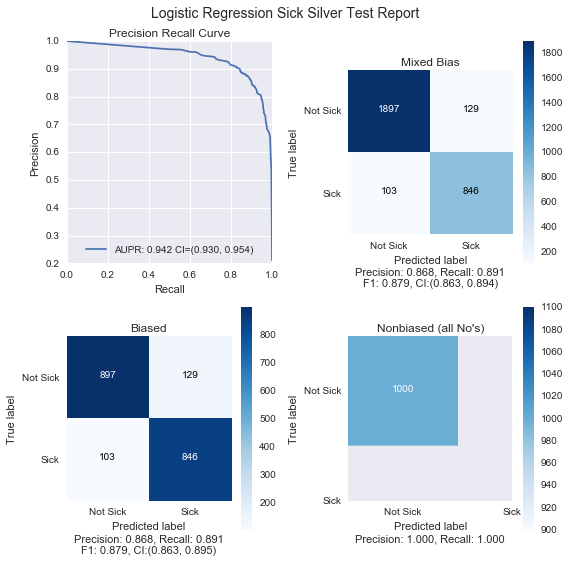

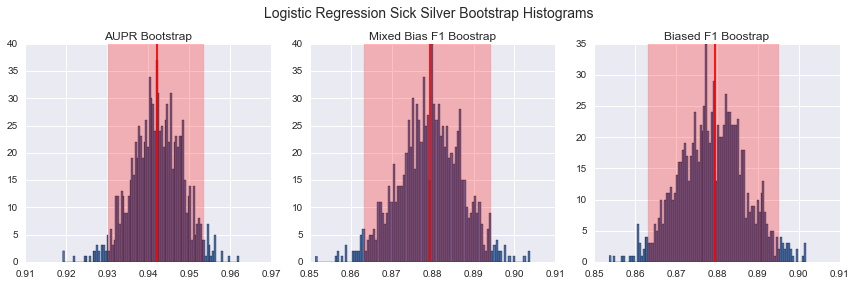

In [16]:
start = time.time()
title = 'Logistic Regression Sick Silver'
all_results[title] = model_report(best_sick_lr_silver, title, 'is_foodborne', 
                                  test_data=test_data,
                                  save_fname='figures/sick_lr_silver',
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))

### Precision Recall Tradeoffs

We'd like to explore how we lose precision with the LR models, as we gain recall. This can be visualized by looking at the high recall region of the PR curves. 

In the curve we can see that all of the model precision begins to drop around a recall of .8 start to significantly drop precision around a recall of .9

(<matplotlib.figure.Figure at 0x11ad71750>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12f287710>)

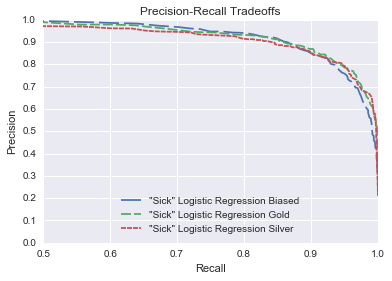

In [17]:
pr_curves([best_sick_lr_biased, best_sick_lr_gold, best_sick_lr_silver], 
          ['"Sick" Logistic Regression Biased', 
           '"Sick" Logistic Regression Gold', 
           '"Sick" Logistic Regression Silver'], 
          'Precision-Recall Tradeoffs', 'is_foodborne', 
          dashes=[[20,5], [10,3], [5,1]],
          test_data=test_data, save_fname='figures/paper_sick_lr',
          figsize=(6,4),
          xlim=(.5,1.),
          yticks=.1*np.arange(11))

In [18]:
print_model_hyperparams(best_sick_lr_biased, 'Logistic Regression Sick Biased')
print()
print_model_hyperparams(best_sick_lr_gold, 'Logistic Regression Sick Gold')
print()
print_model_hyperparams(best_sick_lr_silver, 'Logistic Regression Sick Silver')
print()

*** Logistic Regression Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.97566006470924216,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 3),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'logreg__C': 47.246260126281484,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'ovr',
 'logreg__n_jobs': 1,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False,
 'tfidf__norm': 'l2

### Sick: Random Forest

In [19]:
best_sick_rf_biased.fit(biased_text, biased_sick, rf__sample_weight=biased_weights)
best_sick_rf_gold.fit(gold_text, gold_sick, rf__sample_weight=gold_weights)
best_sick_rf_silver.fit(silver_text, silver_sick, rf__sample_weight=silver_weights)
print()


B: 999/1000
B: 999/1000
B: 999/1000
528 seconds



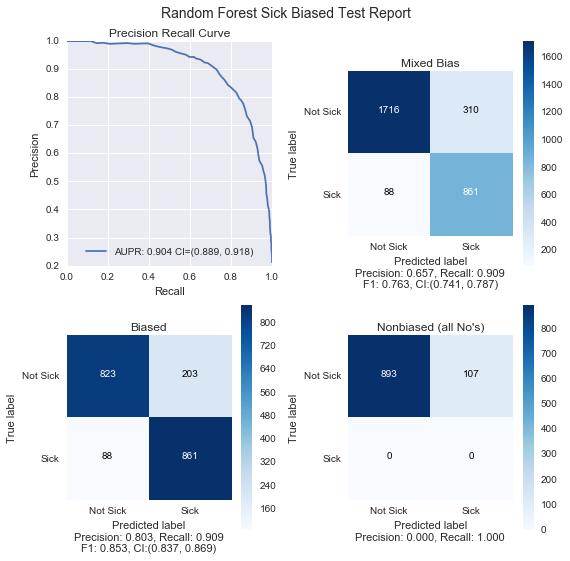

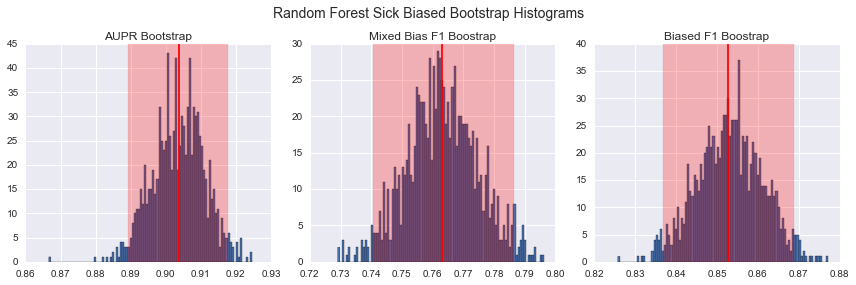

In [20]:
start = time.time()
title = 'Random Forest Sick Biased'
all_results[title] = model_report(best_sick_rf_biased, title, 'is_foodborne',
                                  save_fname='figures/sick_rf_biased',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
640 seconds



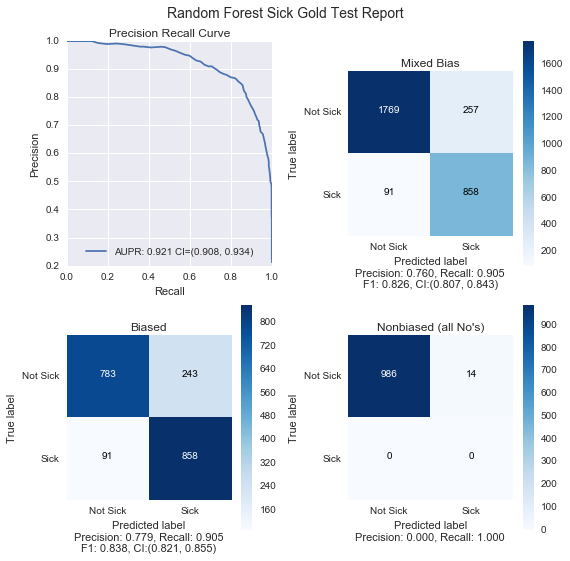

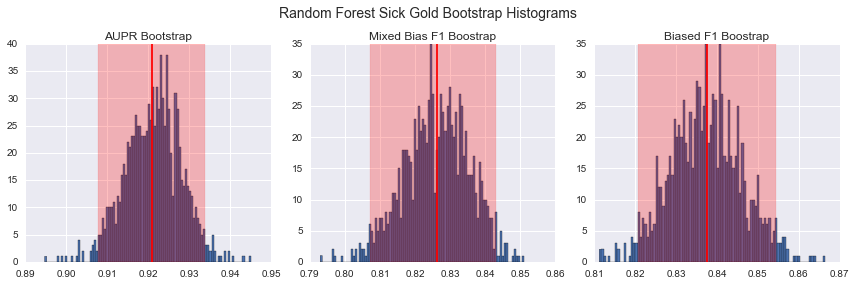

In [21]:
start = time.time()
title = 'Random Forest Sick Gold'
all_results[title] = model_report(best_sick_rf_gold, title, 'is_foodborne',
                                  save_fname='figures/sick_rf_gold',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
650 seconds



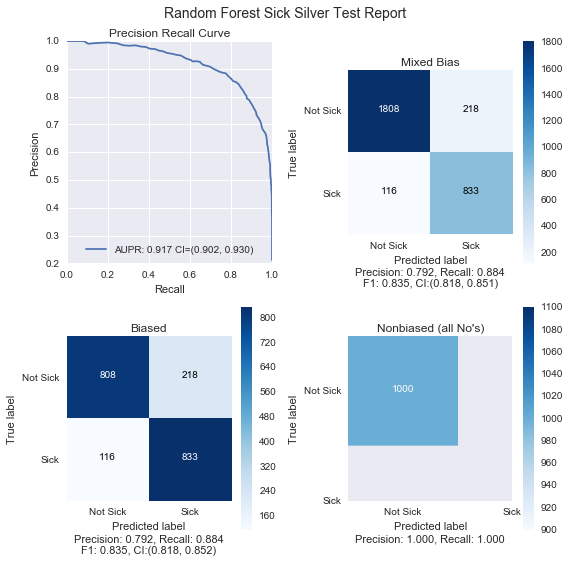

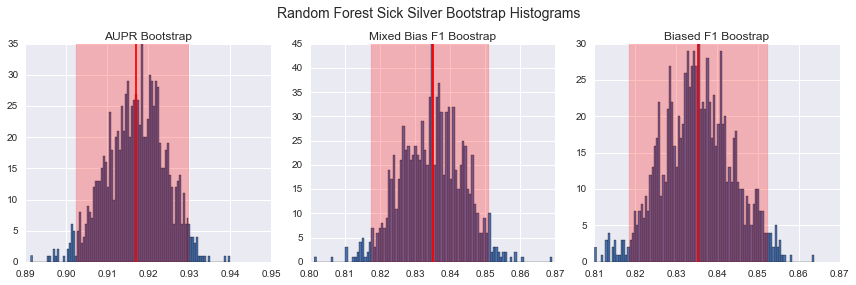

In [22]:
start = time.time()
title = 'Random Forest Sick Silver'
all_results[title] = model_report(best_sick_rf_silver, title, 'is_foodborne',
                                  save_fname='figures/sick_rf_silver',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))

In [23]:
print_model_hyperparams(best_sick_rf_biased, 'Random Forest Sick Biased')
print()
print_model_hyperparams(best_sick_rf_gold, 'Random Forest Sick Gold')
print()
print_model_hyperparams(best_sick_rf_silver, 'Random Forest Sick Silver')
print()

*** Random Forest Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.84951375678004992,
 'count__max_features': 1000,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'rf__bootstrap': True,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__min_impurity_split': 1e-07,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 184,
 'rf__n_jobs': 1,
 'rf__oob_score': True,
 'rf__random_state': 0,
 'rf__verbose': 0,
 'rf__warm_start': False,

### Sick: SVM

In [24]:
best_sick_svm_biased.fit(biased_text, biased_sick, svc__sample_weight=biased_weights)
best_sick_svm_gold.fit(gold_text, gold_sick, svc__sample_weight=gold_weights)
best_sick_svm_silver.fit(silver_text, silver_sick, svc__sample_weight=silver_weights)
print()


B: 999/1000
B: 999/1000
B: 999/1000
658 seconds



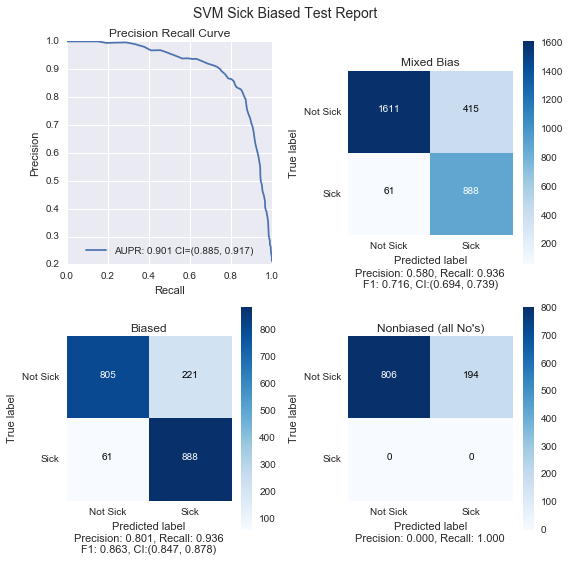

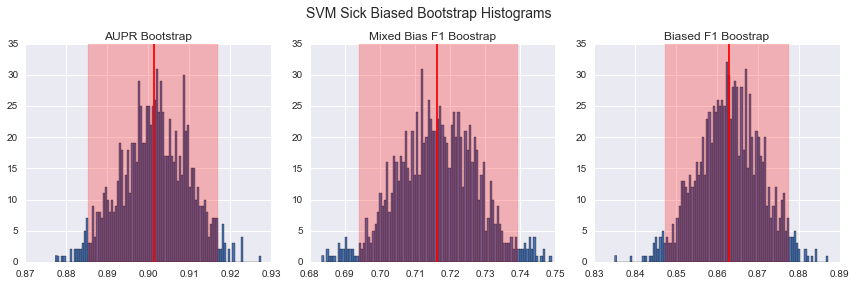

In [26]:
start = time.time()
title = 'SVM Sick Biased'
all_results[title] = model_report(best_sick_svm_biased, title, 'is_foodborne',
                                  save_fname='figures/sick_svm_biased',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
767 seconds



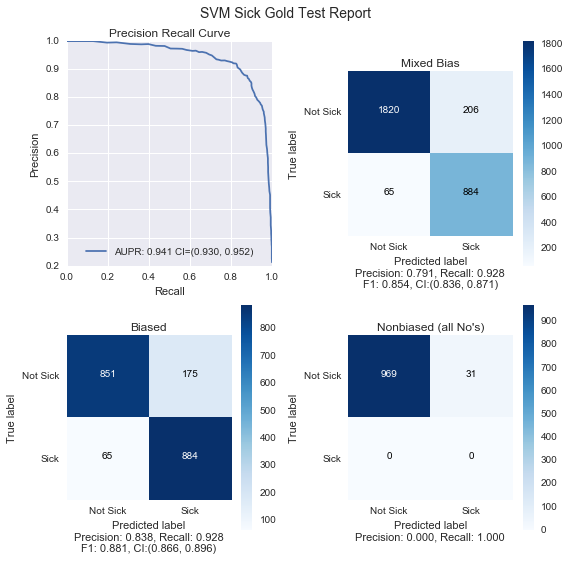

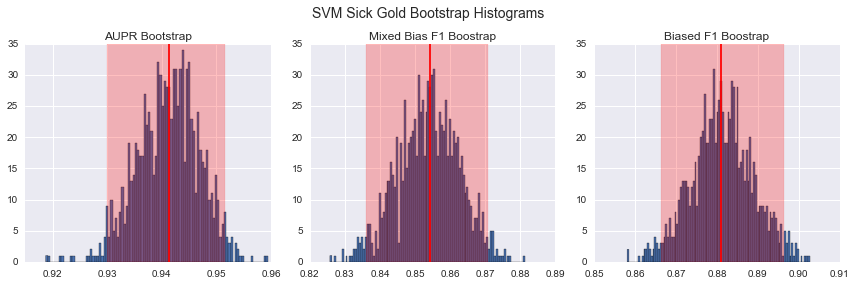

In [27]:
start = time.time()
title = 'SVM Sick Gold'
all_results[title] = model_report(best_sick_svm_gold, title, 'is_foodborne',
                                  save_fname='figures/sick_svm_gold',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
531 seconds



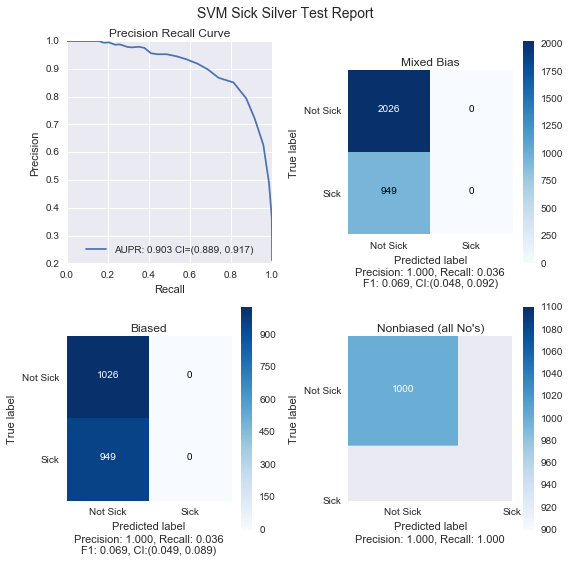

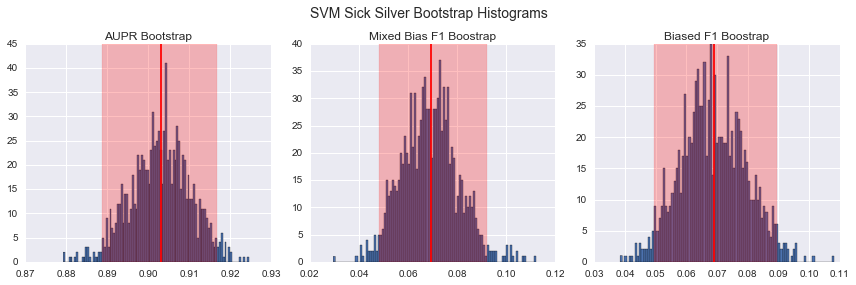

In [28]:
start = time.time()
title = 'SVM Sick Silver'
all_results[title] = model_report(best_sick_svm_silver, title, 'is_foodborne',
                                  save_fname='figures/sick_svm_silver',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))

In [29]:
print_model_hyperparams(best_sick_svm_biased, 'SVM Sick Biased')
print()
print_model_hyperparams(best_sick_svm_gold, 'SVM Sick Gold')
print()
print_model_hyperparams(best_sick_svm_silver, 'SVM Sick Silver')
print()

*** SVM Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.81119879980332688,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'svc__C': 1.0712799833880016,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': None,
 'svc__degree': 3,
 'svc__gamma': 'auto',
 'svc__kernel': 'linear',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False,
 'tfidf__norm': None,
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': Fal

### Sick: Prototype

The prototype classifier is build in the Weka library in Java. To evaluate this, we ran the model on the same test data in the java environment and output the scores to csv.

In [30]:
prototype_sick_scores = pd.read_csv('data/prototype_sick_scores.csv')
prototype_sick_scores.head()

,Unnamed: 0,score
0,0,0.595181
1,1,0.578281
2,2,0.539261
3,3,0.907110
4,4,0.834334



B: 999/1000
B: 999/1000
B: 999/1000


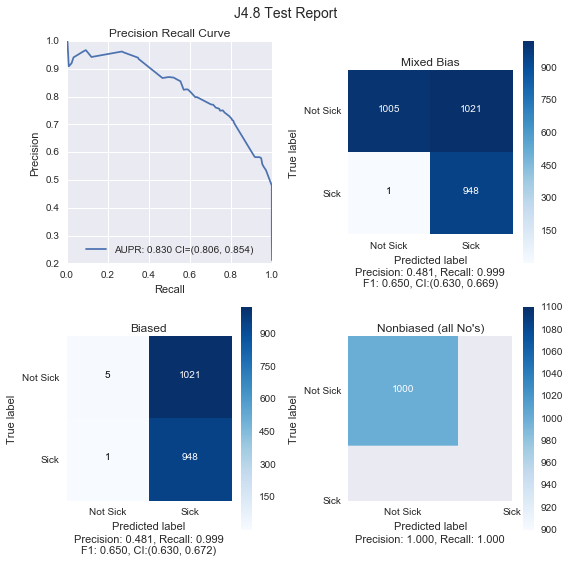

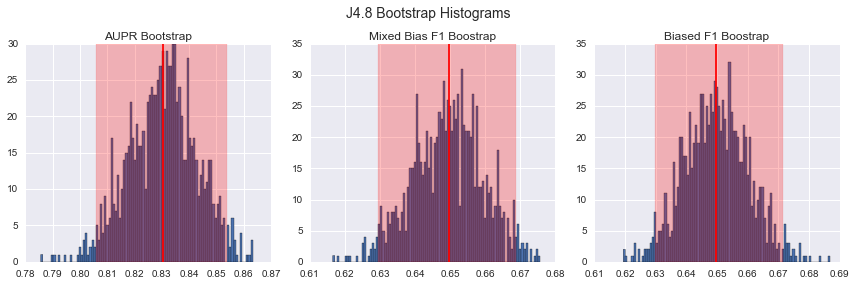

In [31]:
prototype_sick_results = prototype_model_report(test_data['is_foodborne'], 
                                    prototype_sick_scores['score'].tolist(), 
                                    test_data['is_biased'], 'J4.8', 
                                    B=B, random_seed=random_seed)
all_results['Prototype Sick'] = prototype_sick_results

# Multiple Task

Here are the notable stats for testing on the Multple task:
* All the test data is from 1/1/2017 and later
* It's about 2/3 biased and 1/3 nonbiased (1975 and 1000 reviews, respectively)
* All 1000 nonbiased reviews all have `No` labels
* The 1975 biased reviews are about 14% `Yes` (277 `Yes`, 1698 `No`)

### Multiple: Logistic Regression

In [32]:
best_mult_lr_biased.fit(biased_text, biased_mult, logreg__sample_weight=biased_weights)
best_mult_lr_gold.fit(gold_text, gold_mult, logreg__sample_weight=gold_weights)
best_mult_lr_silver.fit(silver_text, silver_mult, logreg__sample_weight=silver_weights)
print()


B: 999/1000
B: 999/1000
B: 999/1000
713 seconds



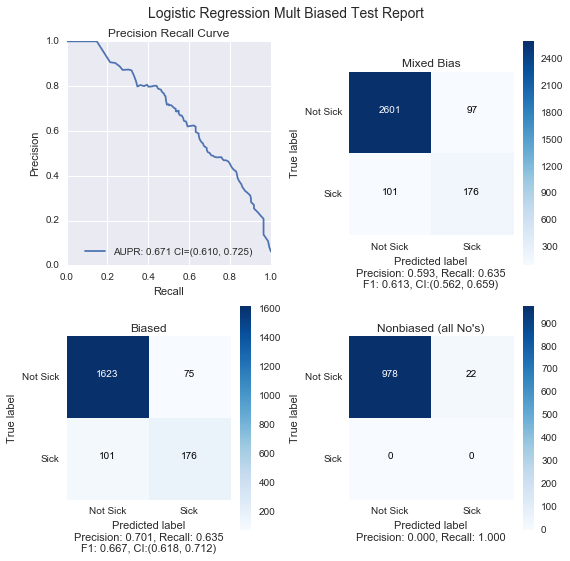

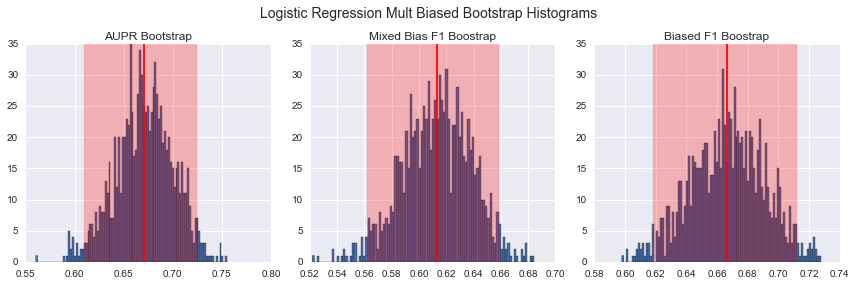

In [33]:
start = time.time()
title = 'Logistic Regression Mult Biased'
all_results[title] = model_report(best_mult_lr_biased, title, 'is_multiple',
                                  save_fname='figures/mult_lr_biased',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
598 seconds



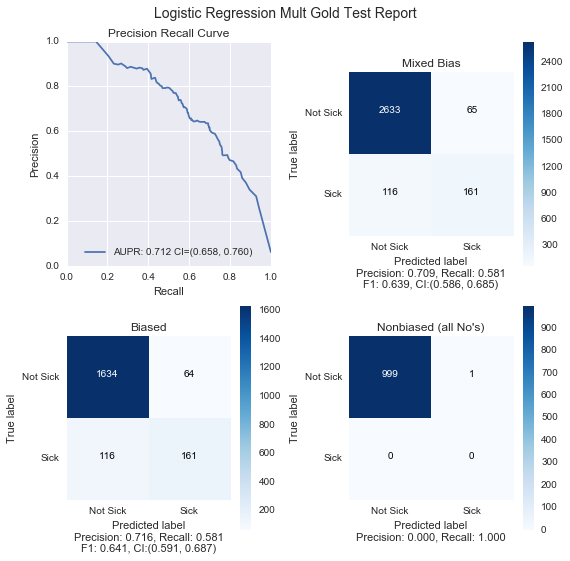

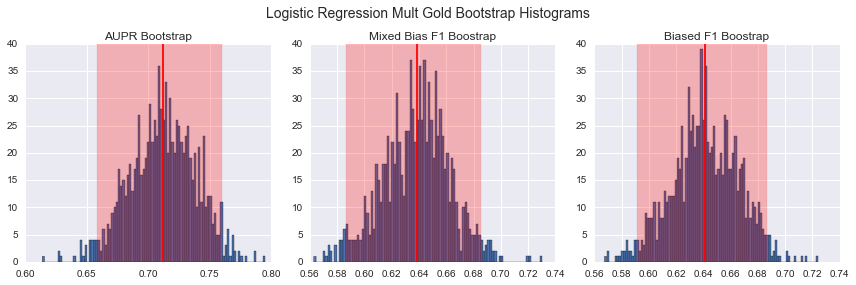

In [34]:
start = time.time()
title = 'Logistic Regression Mult Gold'
all_results[title] = model_report(best_mult_lr_gold, title, 'is_multiple',
                                  save_fname='figures/mult_lr_gold',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000597 seconds



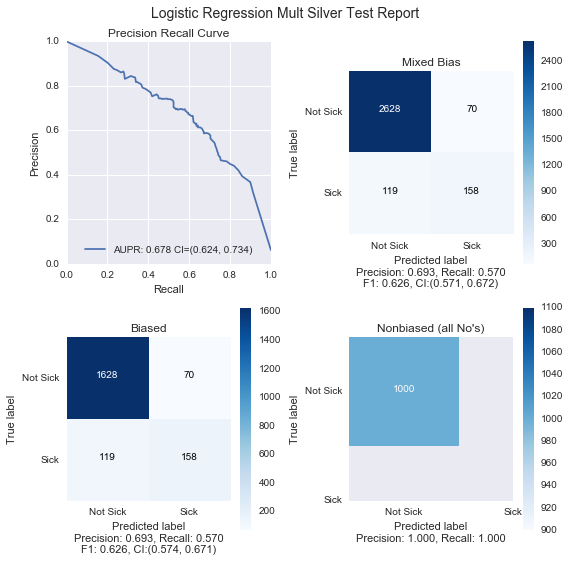

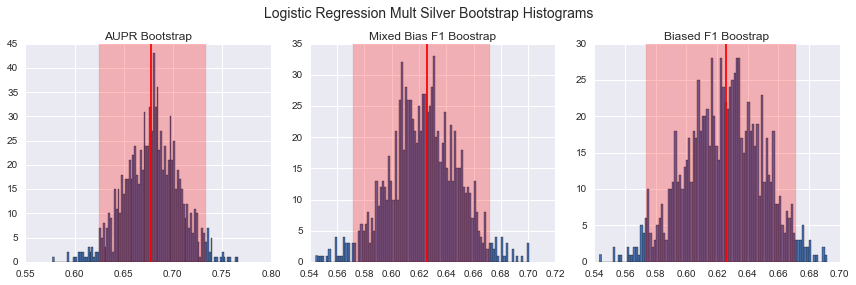

In [35]:
start = time.time()
title = 'Logistic Regression Mult Silver'
all_results[title] = model_report(best_mult_lr_silver, title, 'is_multiple',
                                  save_fname='figures/mult_lr_silver',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('{} seconds'.format(int(time.time()-start)))

In [36]:
print_model_hyperparams(best_mult_lr_biased, 'Logistic Regression Mult Biased')
print()
print_model_hyperparams(best_mult_lr_gold, 'Logistic Regression Mult Gold')
print()
print_model_hyperparams(best_mult_lr_silver, 'Logistic Regression Mult Silver')
print()

*** Logistic Regression Mult Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.96885427226423126,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 3),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'logreg__C': 5.1578801571041133,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'ovr',
 'logreg__n_jobs': 1,
 'logreg__penalty': 'l1',
 'logreg__random_state': None,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False,
 'tfidf__norm': 'l2

### Multiple: Pipelined Logistic Regression

Since the Multiple is always conditioned on Sick=Yes (by definition), it makes more sense to train and use the Multuple model only on data where Sick=Yes. This may allow the model to focus better on Multiple-related features and not need to also learn the Sick class.

We try this technique for all three training regimes.

In [37]:
class MultPipeline():
    def __init__(self, sick_model, mult_model, sick_threshold=.5):
        self.sick_model = sick_model
        self.mult_model = mult_model
        self.t = sick_threshold
    
    def predict_proba(self, xs):
        sick_probs = self.sick_model.predict_proba(xs)
        not_sick = sick_probs[:,1] < self.t
        mult_probs = self.mult_model.predict_proba(xs)
        mult_probs[not_sick] = sick_probs[not_sick]
        return mult_probs
    
    def predict(self, xs):
        return (self.predict_proba(xs)[:,1] >= self.t).astype(np.int32)

In [38]:
sick_only = biased_sick.astype(np.bool)
sick_only_text = biased_text[sick_only]
sick_only_mult = biased_mult[sick_only]
sick_only_weights = biased_weights[sick_only]
print("{} training data / {} orginally".format(len(sick_only_text), len(biased_text)))
print("{0:2.2f}% yes, {1:2.2f}% biased".format(
    100.*sick_only_mult.sum()/len(sick_only_mult), 
    100.*np.array(biased_data['train_data']['is_biased'])[sick_only].sum()/len(sick_only_mult), 
))

5894 training data / 11551 orginally
24.82% yes, 100.00% biased


#### Biased

In [39]:
sick_only_mult_lr_biased = deepcopy(best_mult_lr_biased)

In [40]:
sick_only_mult_lr_biased.fit(sick_only_text, sick_only_mult, logreg__sample_weight=sick_only_weights)
sick_only_mult_model_biased = MultPipeline(best_sick_lr_biased, sick_only_mult_lr_biased)


B: 999/1000
B: 999/1000
B: 999/1000


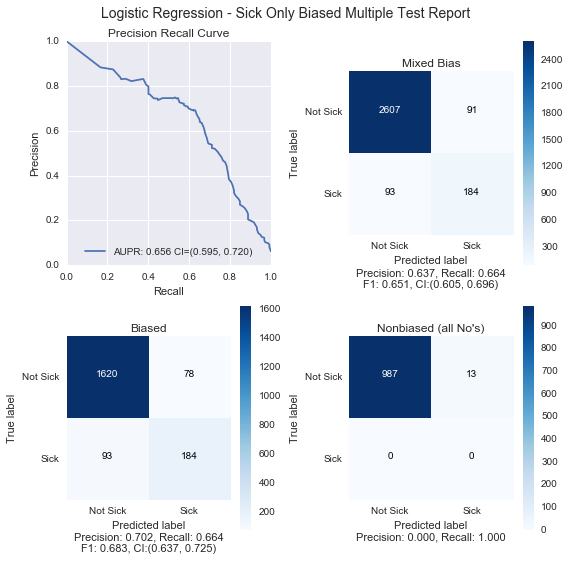

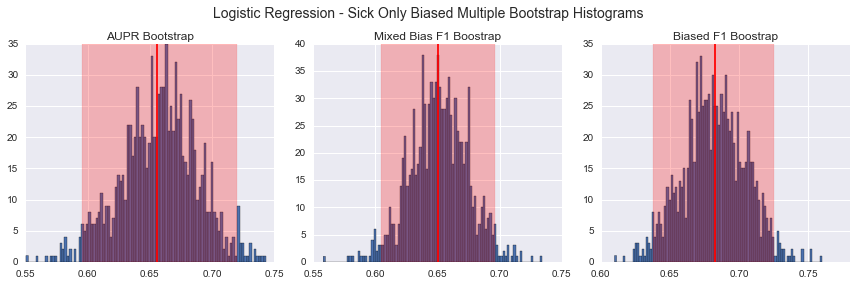

In [43]:
title = 'Logistic Regression - Sick Only Biased Multiple'
all_results[title] = model_report(sick_only_mult_model_biased, title, 
                                  'is_multiple', 
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)

#### Gold

In [44]:
sick_only_mult_lr_gold = deepcopy(best_mult_lr_gold)

In [45]:
sick_only_mult_lr_gold.fit(sick_only_text, sick_only_mult, logreg__sample_weight=sick_only_weights)
sick_only_mult_model_gold = MultPipeline(best_sick_lr_gold, sick_only_mult_lr_gold)


B: 999/1000
B: 999/1000
B: 999/1000


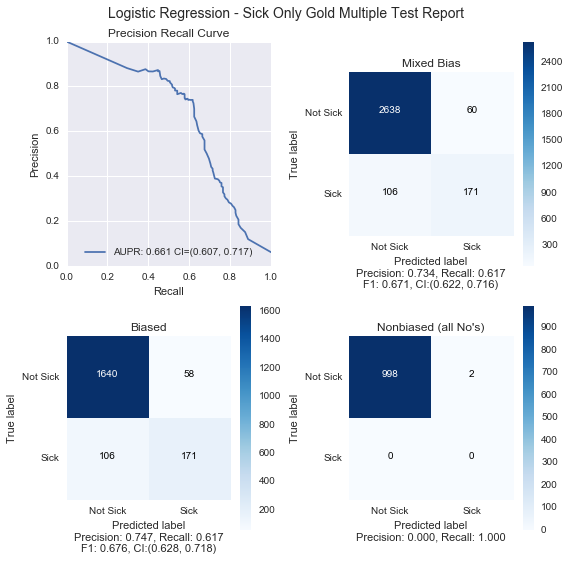

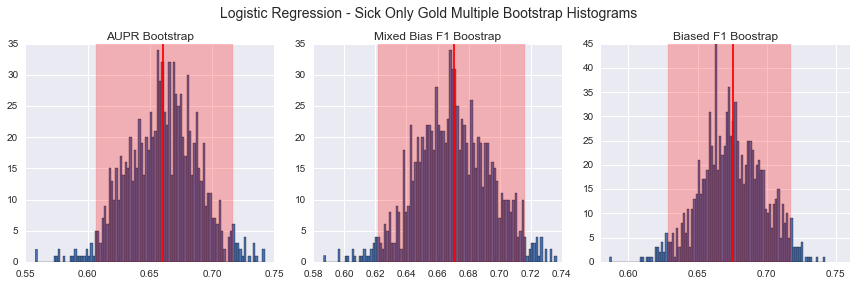

In [47]:
title = 'Logistic Regression - Sick Only Gold Multiple'
all_results[title] = model_report(sick_only_mult_model_gold, title, 'is_multiple', 
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)

#### Silver

In [48]:
sick_only_mult_lr_silver = deepcopy(best_mult_lr_silver)

In [49]:
sick_only_mult_lr_silver.fit(sick_only_text, sick_only_mult, logreg__sample_weight=sick_only_weights)
sick_only_mult_model_silver = MultPipeline(best_sick_lr_silver, sick_only_mult_lr_silver)


B: 999/1000
B: 999/1000
B: 999/1000


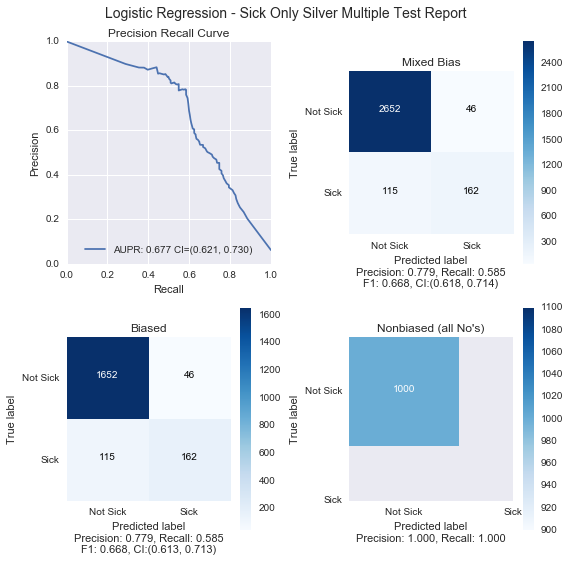

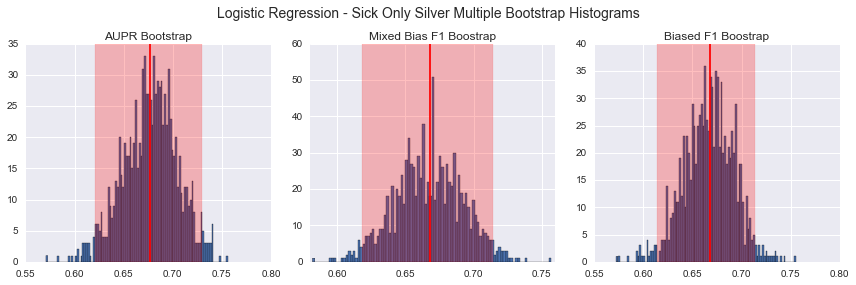

In [50]:
title = 'Logistic Regression - Sick Only Silver Multiple'
all_results[title] = model_report(sick_only_mult_model_silver, title, 'is_multiple', 
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)

### Multiple: Random Forest

In [51]:
best_mult_rf_biased.fit(biased_text, biased_mult, rf__sample_weight=biased_weights)
best_mult_rf_gold.fit(gold_text, gold_mult, rf__sample_weight=gold_weights)
best_mult_rf_silver.fit(silver_text, silver_mult, rf__sample_weight=silver_weights)
print()


B: 999/1000
B: 999/1000
B: 999/1000
541 seconds



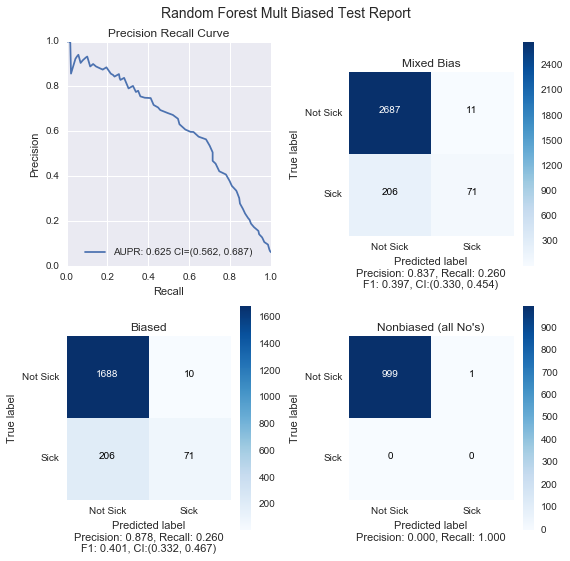

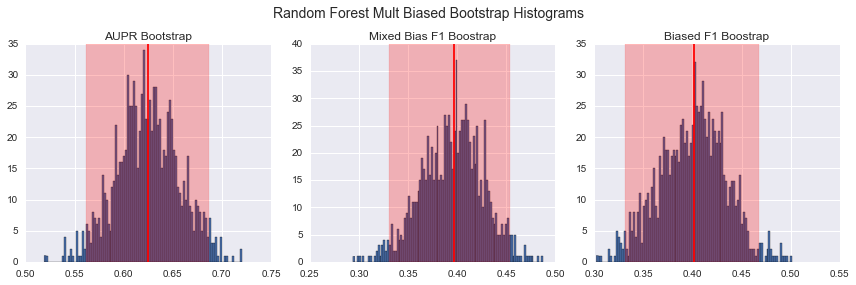

In [52]:
start = time.time()
title = 'Random Forest Mult Biased'
all_results[title] = model_report(best_mult_rf_biased, title, 'is_multiple',
                                  save_fname='figures/mult_rf_biased',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
541 seconds



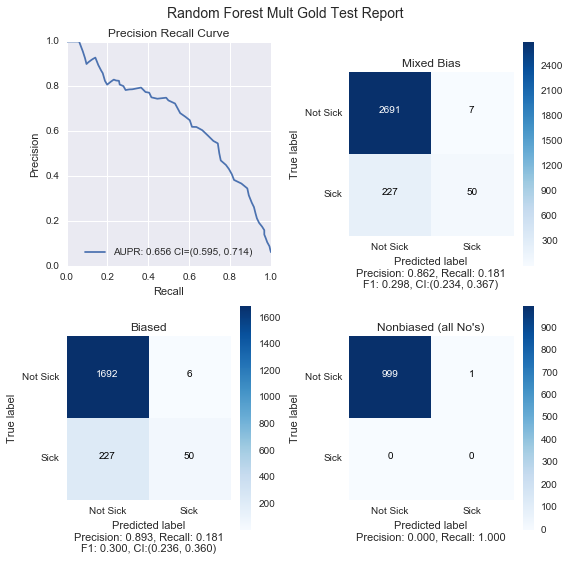

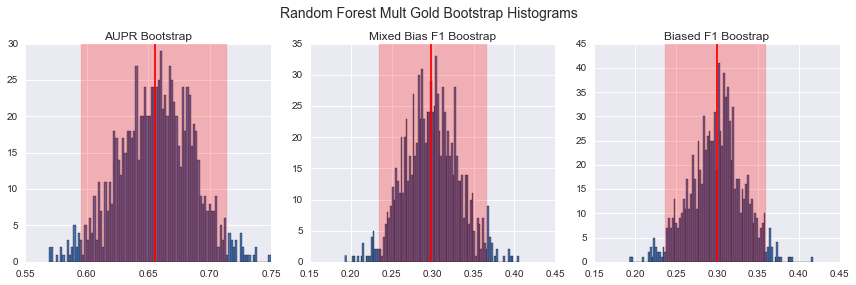

In [53]:
start = time.time()
title = 'Random Forest Mult Gold'
all_results[title] = model_report(best_mult_rf_gold, title, 'is_multiple',
                                  save_fname='figures/mult_rf_gold',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
526 seconds



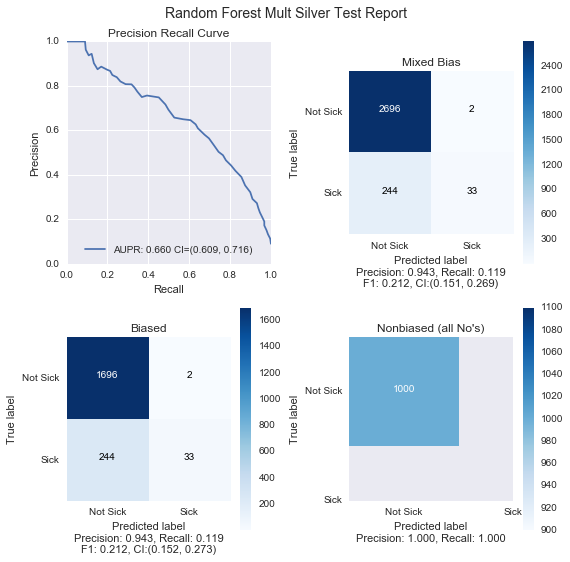

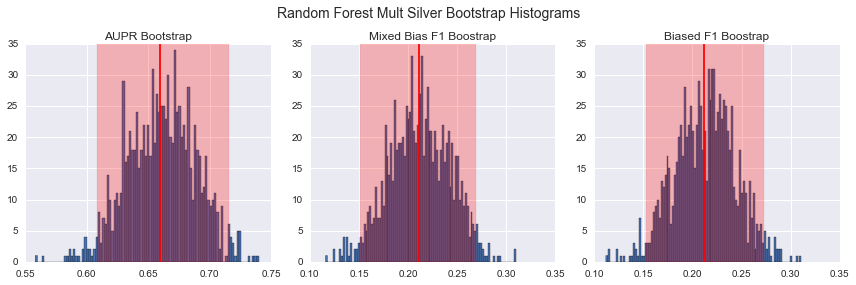

In [54]:
start = time.time()
title = 'Random Forest Mult Silver'
all_results[title] = model_report(best_mult_rf_silver, title, 'is_multiple',
                                  save_fname='figures/mult_rf_silver',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))

In [55]:
print_model_hyperparams(best_mult_rf_biased, 'Random Forest Mult Biased')
print()
print_model_hyperparams(best_mult_rf_gold, 'Random Forest Mult Gold')
print()
print_model_hyperparams(best_mult_rf_silver, 'Random Forest Mult Silver')
print()

*** Random Forest Mult Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.94297444851365897,
 'count__max_features': 1000,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'rf__bootstrap': True,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__min_impurity_split': 1e-07,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 182,
 'rf__n_jobs': 1,
 'rf__oob_score': True,
 'rf__random_state': 0,
 'rf__verbose': 0,
 'rf__warm_start': False,

### Multiple: SVM

In [56]:
best_mult_svm_biased.fit(biased_text, biased_mult, svc__sample_weight=biased_weights)
best_mult_svm_gold.fit(gold_text, gold_mult, svc__sample_weight=gold_weights)
best_mult_svm_silver.fit(silver_text, silver_mult, svc__sample_weight=silver_weights)
print()


B: 999/1000
B: 999/1000
B: 999/1000
600 seconds



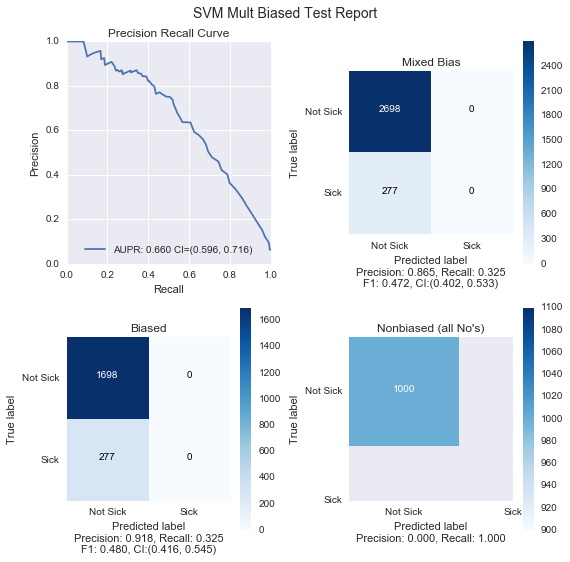

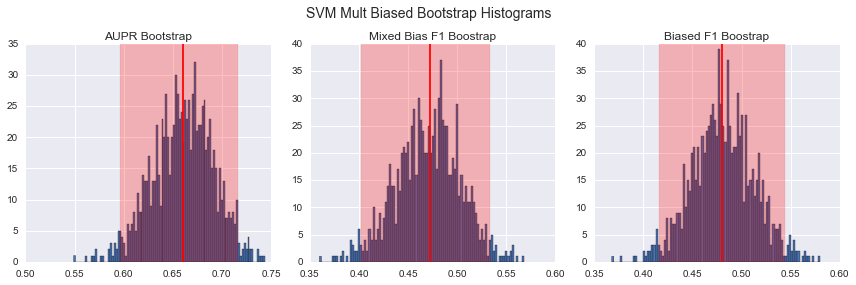

In [57]:
start = time.time()
title = 'SVM Mult Biased'
all_results[title] = model_report(best_mult_svm_biased, title, 'is_multiple',
                                  save_fname='figures/mult_svm_biased',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
614 seconds



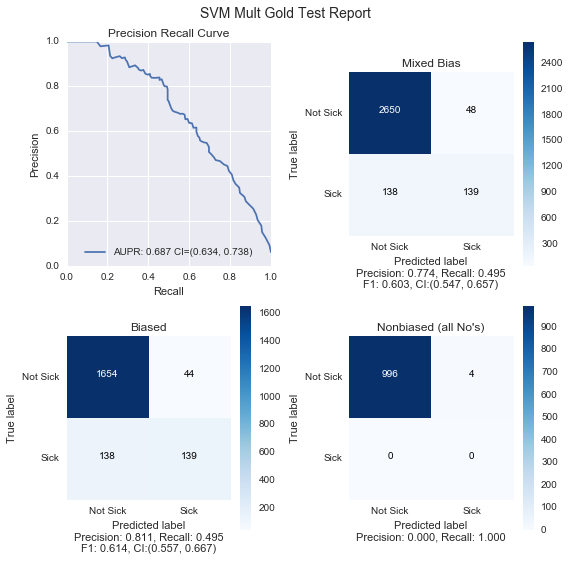

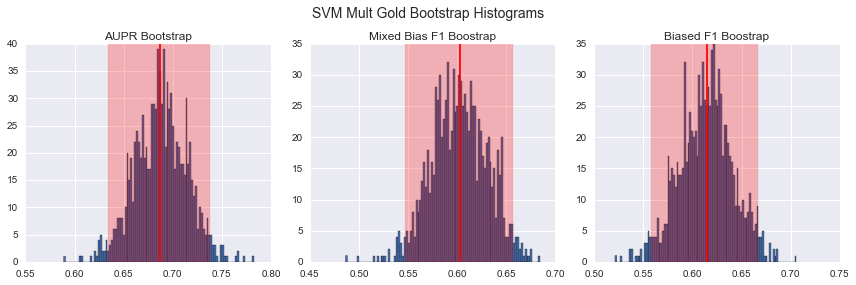

In [58]:
start = time.time()
title = 'SVM Mult Gold'
all_results[title] = model_report(best_mult_svm_gold, title, 'is_multiple',
                                  save_fname='figures/mult_svm_gold',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))


B: 999/1000
B: 999/1000
B: 999/1000
543 seconds



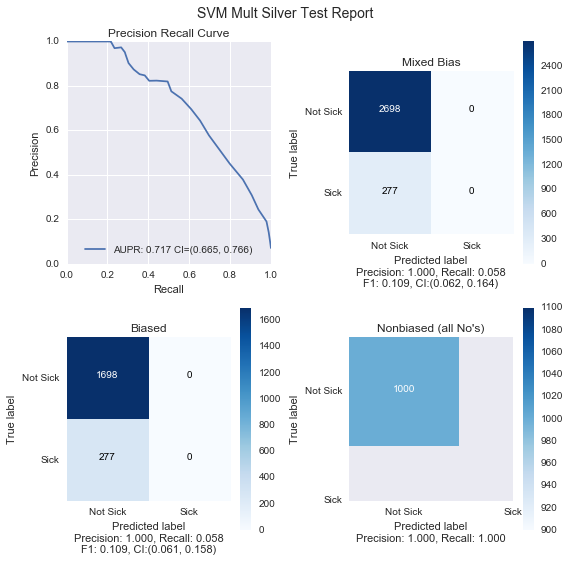

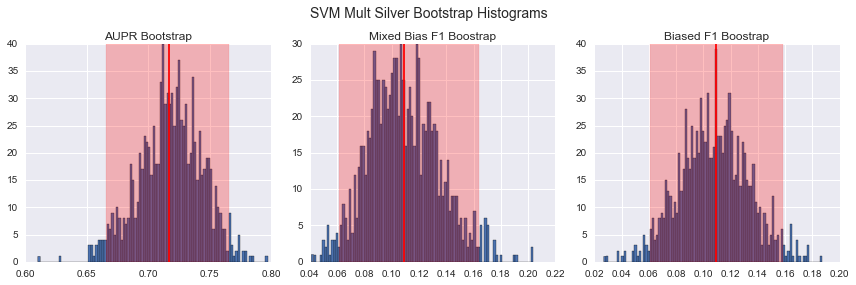

In [59]:
start = time.time()
title = 'SVM Mult Silver'
all_results[title] = model_report(best_mult_svm_silver, title, 'is_multiple',
                                  save_fname='figures/mult_svm_silver',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print('\n{} seconds'.format(int(time.time()-start)))

In [60]:
print_model_hyperparams(best_mult_svm_biased, 'SVM Mult Biased')
print()
print_model_hyperparams(best_mult_svm_gold, 'SVM Mult Gold')
print()
print_model_hyperparams(best_mult_svm_silver, 'SVM Mult Silver')
print()

*** SVM Mult Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.77321625014344464,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'svc__C': 0.55052123745597503,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': None,
 'svc__degree': 3,
 'svc__gamma': 'auto',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False

### Multiple: Prototype

The prototype classifier is build in the Weka library in Java. To evaluate this, we ran the model on the same test data in the java environment and output the scores to csv.

In [61]:
prototype_mult_scores = pd.read_csv('data/prototype_mult_scores.csv')
prototype_mult_scores.head()

,Unnamed: 0,score
0,0,1.000000
1,1,0.055556
2,2,0.666667
3,3,1.000000
4,4,1.000000



B: 999/1000
B: 999/1000
B: 999/1000


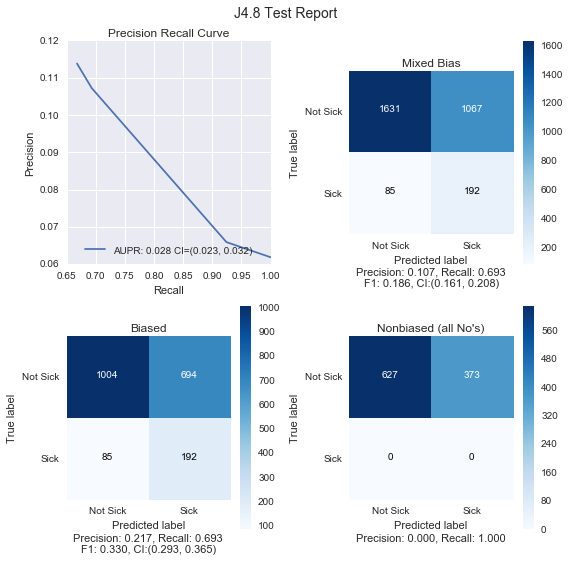

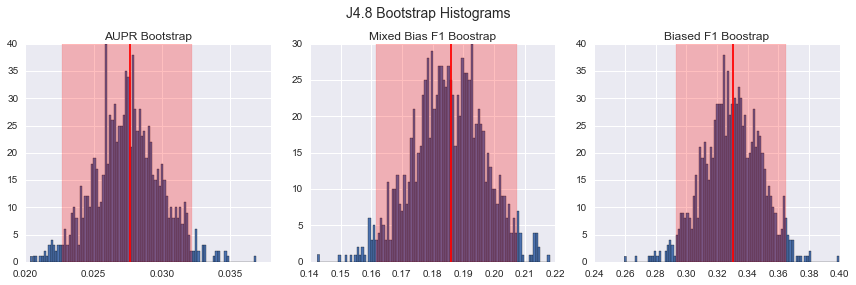

In [62]:
prototype_mult_results = prototype_model_report(test_data['is_multiple'], 
                                    prototype_mult_scores['score'].tolist(), 
                                    test_data['is_biased'], 'J4.8', 
                                    B=B, random_seed=random_seed)
all_results['Prototype Multiple'] = prototype_mult_results

## Compile the scores into a nice table

In [72]:
sick_table = pd.DataFrame()
mult_table = pd.DataFrame()
for name, result in sorted(all_results.items(), key=lambda x:x[0]):
    data = {k:v for k,v in result.items() if ('samples' not in k) and ('_ci' not in k) }
    data.update({k+'_b':v[0] for k,v in result.items() if '_ci' in k})
    data.update({k+'_t':v[1] for k,v in result.items() if '_ci' in k})
    data['name'] = name
    if 'Sick' in name and 'Sick Only' not in name:
        sick_table = sick_table.append(data, ignore_index=True)
    else:
        mult_table = mult_table.append(data, ignore_index=True)
sick_table.set_index('name', inplace=True)
mult_table.set_index('name', inplace=True)

In [73]:
print(sick_table.columns)

Index([u'aupr', u'aupr_ci_b', u'aupr_ci_t', u'biased_f1', u'biased_f1_ci_b',
       u'biased_f1_ci_t', u'biased_precision', u'biased_recall', u'mixed_f1',
       u'mixed_f1_ci_b', u'mixed_f1_ci_t', u'mixed_precision',
       u'mixed_recall'],
      dtype='object')


In [74]:
sick_table.to_csv('sick_results.csv')
sick_table[['mixed_f1', 'mixed_f1_ci_b', 'mixed_f1_ci_t']]

,mixed_f1,mixed_f1_ci_b,mixed_f1_ci_t
name,,,
Logistic Regression Sick Biased,0.840710,0.822193,0.859745
Logistic Regression Sick Gold,0.867140,0.850094,0.882386
Logistic Regression Sick Silver,0.879418,0.863256,0.894168
Prototype Sick,0.649760,0.629564,0.668704
Random Forest Sick Biased,0.763083,0.740541,0.786520
Random Forest Sick Gold,0.826288,0.807280,0.843026
Random Forest Sick Silver,0.835241,0.817577,0.851025
SVM Sick Biased,0.716147,0.693927,0.739269
SVM Sick Gold,0.854131,0.836096,0.870721


In [75]:
sick_table

,aupr,aupr_ci_b,aupr_ci_t,biased_f1,biased_f1_ci_b,biased_f1_ci_t,biased_precision,biased_recall,mixed_f1,mixed_f1_ci_b,mixed_f1_ci_t,mixed_precision,mixed_recall
name,,,,,,,,,,,,,
Logistic Regression Sick Biased,0.951823,0.941689,0.961292,0.881836,0.866659,0.896421,0.821656,0.951528,0.840710,0.822193,0.859745,0.753012,0.951528
Logistic Regression Sick Gold,0.950086,0.938756,0.959914,0.876604,0.860176,0.891273,0.824513,0.935722,0.867140,0.850094,0.882386,0.807925,0.935722
Logistic Regression Sick Silver,0.942067,0.930207,0.953751,0.879418,0.863113,0.895199,0.867692,0.891465,0.879418,0.863256,0.894168,0.867692,0.891465
Prototype Sick,0.830456,0.805858,0.853993,0.649760,0.629823,0.671617,0.481463,0.998946,0.649760,0.629564,0.668704,0.481463,0.998946
Random Forest Sick Biased,0.903663,0.889288,0.917629,0.852767,0.836699,0.868783,0.802791,0.909378,0.763083,0.740541,0.786520,0.657334,0.909378
Random Forest Sick Gold,0.920981,0.907819,0.933762,0.837640,0.820637,0.854513,0.779492,0.905163,0.826288,0.807280,0.843026,0.760057,0.905163
Random Forest Sick Silver,0.916915,0.902348,0.929935,0.835241,0.818463,0.852427,0.791509,0.884089,0.835241,0.817577,0.851025,0.791509,0.884089
SVM Sick Biased,0.901450,0.885183,0.916955,0.862974,0.847206,0.877716,0.800721,0.935722,0.716147,0.693927,0.739269,0.580037,0.935722
SVM Sick Gold,0.941353,0.929893,0.951634,0.881000,0.866285,0.896488,0.838249,0.928346,0.854131,0.836096,0.870721,0.790905,0.928346


In [76]:
mult_table.to_csv('mult_results.csv')
mult_table[['mixed_f1', 'mixed_f1_ci_b', 'mixed_f1_ci_t']]

,mixed_f1,mixed_f1_ci_b,mixed_f1_ci_t
name,,,
Logistic Regression - Sick Only Biased Multiple,0.650585,0.604935,0.696044
Logistic Regression - Sick Only Gold Multiple,0.670565,0.621625,0.716343
Logistic Regression - Sick Only Silver Multiple,0.668041,0.617943,0.714039
Logistic Regression Mult Biased,0.613317,0.562133,0.659007
Logistic Regression Mult Gold,0.638883,0.586201,0.685385
Logistic Regression Mult Silver,0.625743,0.571429,0.672177
Prototype Multiple,0.185864,0.161423,0.207552
Random Forest Mult Biased,0.396641,0.330317,0.453543
Random Forest Mult Gold,0.298492,0.234428,0.366714


In [77]:
mult_table

,aupr,aupr_ci_b,aupr_ci_t,biased_f1,biased_f1_ci_b,biased_f1_ci_t,biased_precision,biased_recall,mixed_f1,mixed_f1_ci_b,mixed_f1_ci_t,mixed_precision,mixed_recall
name,,,,,,,,,,,,,
Logistic Regression - Sick Only Biased Multiple,0.656069,0.595139,0.720279,0.682746,0.637401,0.725003,0.702290,0.664260,0.650585,0.604935,0.696044,0.637461,0.664260
Logistic Regression - Sick Only Gold Multiple,0.660567,0.606857,0.716787,0.675889,0.628311,0.717531,0.746725,0.617329,0.670565,0.621625,0.716343,0.733851,0.617329
Logistic Regression - Sick Only Silver Multiple,0.676895,0.620911,0.730171,0.668041,0.613435,0.713403,0.778846,0.584838,0.668041,0.617943,0.714039,0.778846,0.584838
Logistic Regression Mult Biased,0.670862,0.609659,0.724858,0.666667,0.618255,0.712123,0.701195,0.635379,0.613317,0.562133,0.659007,0.592736,0.635379
Logistic Regression Mult Gold,0.712016,0.658248,0.760144,0.641434,0.591303,0.686519,0.715556,0.581227,0.638883,0.586201,0.685385,0.709237,0.581227
Logistic Regression Mult Silver,0.678216,0.624435,0.733556,0.625743,0.573662,0.671388,0.692982,0.570397,0.625743,0.571429,0.672177,0.692982,0.570397
Prototype Multiple,0.027646,0.022655,0.032201,0.330181,0.293494,0.364877,0.216704,0.693141,0.185864,0.161423,0.207552,0.107321,0.693141
Random Forest Mult Biased,0.624604,0.561626,0.687115,0.401114,0.331519,0.467471,0.878049,0.259928,0.396641,0.330317,0.453543,0.836735,0.259928
Random Forest Mult Gold,0.655930,0.595494,0.714098,0.300300,0.236337,0.360252,0.892857,0.180505,0.298492,0.234428,0.366714,0.861804,0.180505


### Write out the final Sick and Multiple classifiers -- Sick LR Silver and Mult LR Pipelined Silver

In [78]:
joblib.dump(best_sick_lr_silver, 'final_models/final_yelp_sick_model.gz')
joblib.dump(sick_only_mult_lr_silver, 'final_models/final_yelp_mult_model.gz')

['final_models/final_yelp_mult_model.gz']